## Popularity-based Recommentation System

In [1]:
#import the reqired libraries
import json
import gzip

import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

We have two data files **Video_Games_5.json.gz** and **meta_Video_Games.json.gz**. <br>
First one contains all the ratings. Each row corresponds to an instance of rating by a user. <br>
The latter is a json that consists of information about the product that is rated. <br>

In [2]:
# Load the video_games.json file into a dataframe
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

video_games_df = getDF('Video_Games_5.json.gz')

In [3]:
video_games_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
import ast
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield ast.literal_eval(l.decode('utf-8'))

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

metadata_df = getDF('meta_Video_Games.json.gz')

In [5]:
metadata_df.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand
0,0078764343,Brand new sealed!,37.98,http://ecx.images-amazon.com/images/I/513h6dPb...,"{'also_bought': ['B000TI836G', 'B003Q53VZC', '...",{'Video Games': 28655},"[[Video Games, Xbox 360, Games]]",NaN,NaN
1,043933702X,In Stock NOW. Eligible for FREE Super Saving ...,23.50,http://ecx.images-amazon.com/images/I/61KKRndV...,"{'also_viewed': ['B000067NP1', '0439573947', '...",{'Video Games': 44080},"[[Video Games, PC, Games]]",NaN,NaN
2,0439339987,Grandma Groupers kelp seeds are missing and wi...,8.95,http://ecx.images-amazon.com/images/I/416QZg89...,"{'also_bought': ['B000314VVU', 'B000PXUOTE', '...",{'Video Games': 49836},"[[Video Games, PC, Games]]",NaN,NaN
3,0439342260,This software is BRAND NEW. Packaging may diff...,NaN,http://ecx.images-amazon.com/images/I/61Wvu-Uj...,{'also_viewed': ['043934302X']},{'Video Games': 49156},"[[Video Games, PC, Games]]",NaN,NaN
4,0439339960,a scholastic clubs fairs cd rom game,NaN,http://ecx.images-amazon.com/images/I/51k3oRCF...,{'also_viewed': ['B00028D7TG']},{'Video Games': 52262},"[[Video Games, PC, Games]]",NaN,NaN


In [6]:
# Merging the meta dataset(contains product info) with the video games dataset(contains ratings)
df = pd.merge(video_games_df, metadata_df, on='asin', how='inner')
display(df.shape)

(359839, 20)

In [7]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image', 'description', 'price', 'imUrl', 'related',
       'salesRank', 'categories', 'title', 'brand'],
      dtype='object')

In [37]:
# Most of these features do not provide any meaningful relevance for a popularity based recommender and hence dropping them..
#columns_dropped = ['asin', 'reviewerName', 'reviewText', 'summary', 'image', 'imUrl']
#columns_dropped.append('vote') # column refers to the upvotes on a review - ~27k are nulls and the other 80k don't seem to provide much info

# dropping all the columns that have description-like data
# These text blocks might have some correlation for a different kind of recommender model
# But for a popularity-based one, analysis of text seemed a bit too far fetched.
#columns_dropped.append('description') # product description
#columns_dropped.append('related') # related products bought
#columns_dropped.append('categories') # categories the product falls under


#df.drop(columns_dropped, axis = 1, inplace = True)
#display(df.shape)

## I went on to drop most columns after analysing one after another.
## I am going to consider a slice of the df for the further part.
## Do not run this cell.

In [9]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,description,price,imUrl,related,salesRank,categories,title,brand
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN,"Anno 2070, the newest version of the award-win...",39.99,http://ecx.images-amazon.com/images/I/51R06L8c...,"{'also_bought': ['B005OM6CGU', 'B001AWMCMQ', '...",{'Video Games': 7621},"[[Video Games, PC, Games]]",NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN,"Anno 2070, the newest version of the award-win...",39.99,http://ecx.images-amazon.com/images/I/51R06L8c...,"{'also_bought': ['B005OM6CGU', 'B001AWMCMQ', '...",{'Video Games': 7621},"[[Video Games, PC, Games]]",NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN,"Anno 2070, the newest version of the award-win...",39.99,http://ecx.images-amazon.com/images/I/51R06L8c...,"{'also_bought': ['B005OM6CGU', 'B001AWMCMQ', '...",{'Video Games': 7621},"[[Video Games, PC, Games]]",NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN,"Anno 2070, the newest version of the award-win...",39.99,http://ecx.images-amazon.com/images/I/51R06L8c...,"{'also_bought': ['B005OM6CGU', 'B001AWMCMQ', '...",{'Video Games': 7621},"[[Video Games, PC, Games]]",NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN,"Anno 2070, the newest version of the award-win...",39.99,http://ecx.images-amazon.com/images/I/51R06L8c...,"{'also_bought': ['B005OM6CGU', 'B001AWMCMQ', '...",{'Video Games': 7621},"[[Video Games, PC, Games]]",NaN,NaN


In [10]:
# Slice the df
videogames_df = df[['overall', 'unixReviewTime', 'reviewerID', 'asin']]

# overall = overall rating
# ASIN = Amazon Standard Identification Number
columns = ['rating', 'reviewTime', 'reviewerID', 'productID']
videogames_df.columns = columns

In [11]:
videogames_df = videogames_df.reindex(columns=['productID', 'reviewerID', 'reviewTime', 'rating'])
display(videogames_df.head())
display(videogames_df.shape)

,productID,reviewerID,reviewTime,rating
0,0700026657,A1HP7NVNPFMA4N,1445040000,5.0
1,0700026657,A1JGAP0185YJI6,1437955200,4.0
2,0700026657,A1YJWEXHQBWK2B,1424649600,3.0
3,0700026657,A2204E1TH211HT,1424390400,2.0
4,0700026657,A2RF5B5H74JLPE,1419465600,5.0


(359839, 4)

In [12]:
print('Number of missing values across columns\n', videogames_df.isnull().sum())

Number of missing values across columns
 productID     0
reviewerID    0
reviewTime    0
rating        0
dtype: int64


**There are no missing values in the dataset.**

## Exploratory Data Analysis

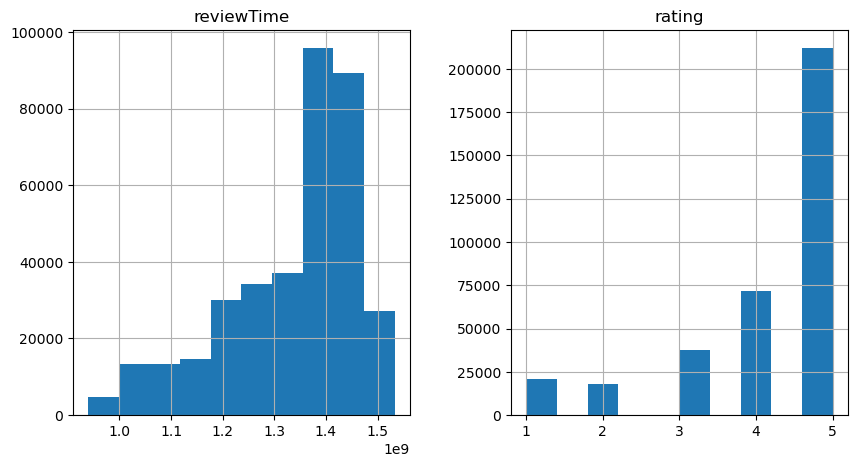

In [13]:
videogames_df.hist(figsize=(10, 5))
plt.show()

There are a huge number of 5-star ratings and rating time does not look like it can give any meaningful information.

In [14]:
videogames_df.drop('reviewTime', axis = 1, inplace = True)

In [15]:
print("A summary of the dataset")
print("-"*50)
print("Number of Ratings          =", videogames_df.shape[0]) # all the data points
print("Number of unique Users     =", len(np.unique(videogames_df.reviewerID)))
print("Number of unique Products  =", len(np.unique(videogames_df.productID)))
print("-"*50)

A summary of the dataset
--------------------------------------------------
Number of Ratings          = 359839
Number of unique Users     = 52807
Number of unique Products  = 13012
--------------------------------------------------


In [16]:
print('Minimum rating is: %d' %(videogames_df.rating.min()))
print('Maximum rating is: %d' %(videogames_df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


Ratings are within ranges of 1 to 5

## Analysis of Ratings

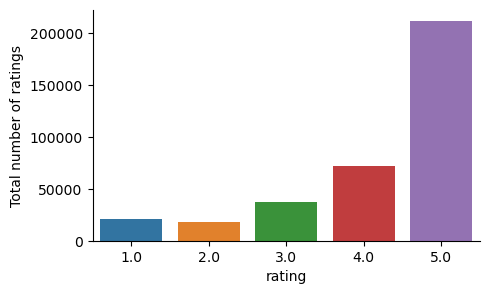

In [17]:
# Checking the distribution of the ratings with a countplot
g = sns.countplot(x='rating', data=videogames_df)
g.set_ylabel("Total number of ratings")
g.figure.set_size_inches(5, 3)
sns.despine()

<Axes: ylabel='rating'>

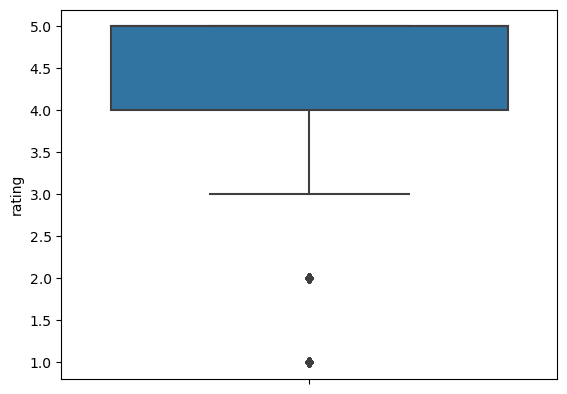

In [18]:
sns.boxplot(y='rating',data=videogames_df)

There are a higher number of 5 star ratings when compared to all others. <br>
Most users have rated the products between 4 and 5

In [19]:
# Display the top 10 users based on counts ratings
videogames_df.drop_duplicates(inplace=True)
most_rated = videogames_df.groupby('reviewerID').size().sort_values(ascending=False)
print('Top 10 users based on ratings: \n\n', most_rated[:10])

Top 10 users based on ratings: 

 reviewerID
A3V6Z4RCDGRC44    762
AJKWF4W7QD4NS     678
A3W4D8XOGLWUN5    461
A2TCG2HV1VJP6V    398
A2QHS1ZCIQOL7E    374
A29BQ6B90Y1R5F    358
A119Q9NFGVOEJZ    323
A2582KMXLK2P06    303
A20DZX38KRBIT8    250
A3GKMQFL05Z79K    226
dtype: int64


In [20]:
counts = videogames_df.reviewerID.value_counts()
videogames_trimmed = videogames_df[videogames_df.reviewerID.isin(counts[counts>=10].index)]
print('Number of users who have rated 10 or more products =', len(videogames_trimmed))
print('Number of unique users in the final dataset = ', videogames_trimmed['reviewerID'].nunique())
print('Number of unique products in the final dataset = ', videogames_trimmed['productID'].nunique())

Number of users who have rated 10 or more products = 133490
Number of unique users in the final dataset =  7224
Number of unique products in the final dataset =  12665


Approximately one-third of the total users have rated at least 10 products. I am going to consider only a subset of the dataset imposing this restriction.

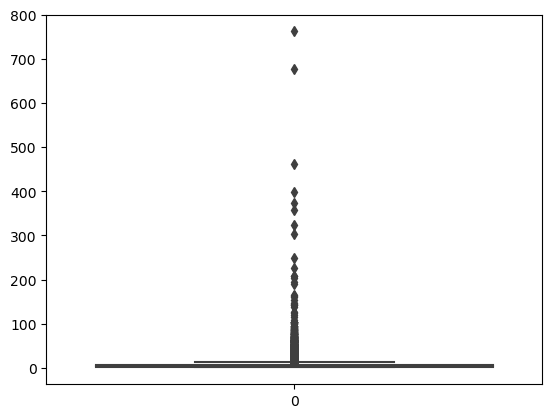

In [21]:
sns.boxplot(data = most_rated);

Box plot shows that we have few users who rate many items (appearing in outliers like 762, 678) but the majority users rate very few items (~under 30)

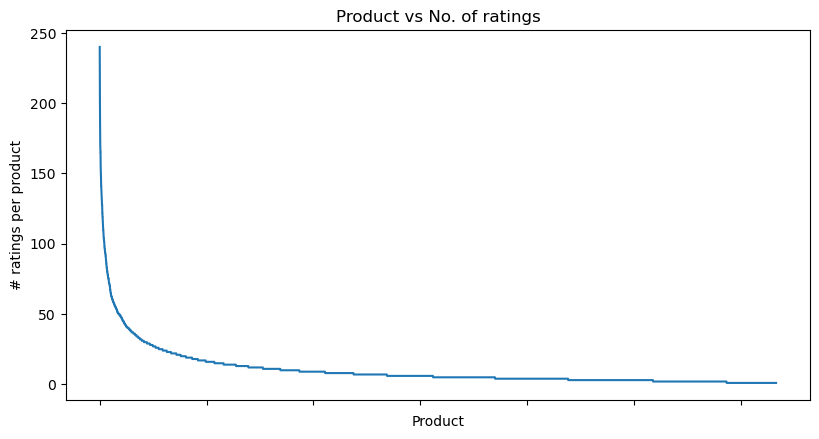

In [22]:
# Products also have skewed ratings with majority of the products having a very few ratings
ratings_per_product = videogames_trimmed.groupby(by='productID')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(ratings_per_product.values)
plt.title('Product vs No. of ratings')
plt.xlabel('Product')
plt.ylabel('# ratings per product')
ax.set_xticklabels([])
plt.show();

In [23]:
ratings_mean_count = pd.DataFrame(videogames_trimmed.groupby('productID')['rating'].mean())
ratings_mean_count['rating_count'] = pd.DataFrame(videogames_trimmed.groupby('productID')['rating'].count())
ratings_mean_count.head()

,rating,rating_count
productID,,
0700026657,3.666667,6
0700099867,3.700000,10
3828770193,4.666667,3
6050036071,4.444444,9
7293000936,5.000000,3


In [24]:
# Maximum number of ratings received for a product is 240
display(ratings_mean_count['rating_count'].max())

240

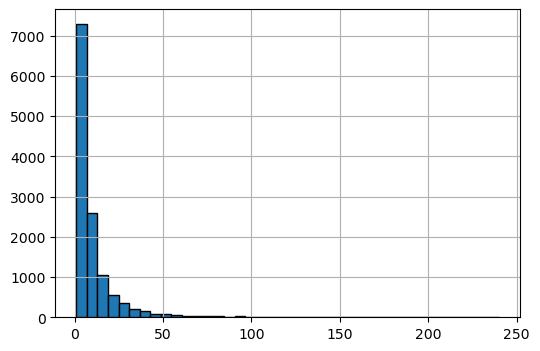

In [25]:
# Majority of the products have only received a single rating 
# Hence, it is a right skewed distribution

plt.figure(figsize=(6,4));
plt.rcParams['patch.force_edgecolor'] = True;
ratings_mean_count['rating_count'].hist(bins=40);
plt.show();

<Figure size 600x400 with 0 Axes>

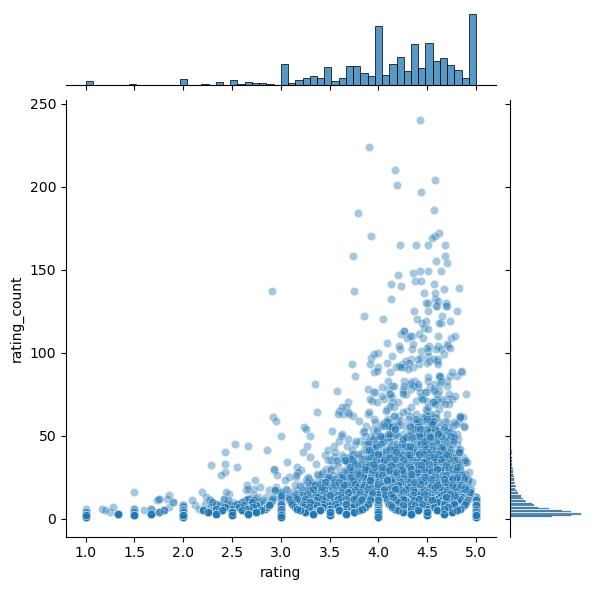

In [26]:
# From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
# and a higher number of users have rated products in the section of outliers.

# For a Popularity-Based system, we can consider recommending them to the users.

plt.figure(figsize=(6,4));
plt.rcParams['patch.force_edgecolor'] = True;
sns.jointplot(x='rating', y='rating_count', data=ratings_mean_count, alpha=0.4);
plt.show();

I don't know why two similar looking boxplots showed up here. I tried to remove one of them and could not.

## Train - Test split

In [27]:
# Split the data into train and test datasets with 80:20 ratio
train_data, test_data = train_test_split(videogames_df, test_size = 0.2, random_state = 50)
train_data.head()

,productID,reviewerID,rating
276116,B00576U8CC,A3LZXB1SBY0GVB,3.0
84189,B000A0XSP4,A3ODOZPPOGAPW4,5.0
906,B00000DMB3,A3713PP4MADKED,5.0
247577,B0047ORROW,A201G0BOTB1XLO,5.0
184923,B00189MNKM,AFJAC5NZ8R5VS,5.0


## Making predictions

In [28]:
# Count of reviewerID for each unique product as its recommendation score
# We can tweak this by considering a weighted voting process.

train_data_grouped = train_data.groupby('productID').agg({'reviewerID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'reviewerID': 'score'},inplace=True)
train_data_grouped.head(10)

,productID,score
0,0700026657,12
1,0700099867,21
2,3828770193,4
3,6050036071,34
4,7293000936,8
5,8176503290,7
6,8565000168,5
7,907843905X,6
8,9625990674,22
9,9882100848,2


In [29]:
# Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productID'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productID,score,rank
7282,B00178630A,547,1.0
9704,B003ZSP0WW,545,2.0
4262,B0009VXBAQ,508,3.0
10359,B0050SYX8W,501,4.0
12190,B00DC7G2W8,493,5.0


## Evaluation of the above Popularity-based model

I am trying to calculating the RMSE of the above popularity based recommendation system model as follows <br>

**Recommendation Score** = Total number of users who have given a rating for the product <br>
**Average rating** = Sum of all the ratings received for a product / Recommendation Score <br>

After calculating the Average ratings in the grouped version of test dataset, Mean squared error for Actual ratings vs Average ratings is computed. <br>
And this is defined as the RMSE for the test dataset.


In [30]:
# Since rating present in the test data is the actual rating, renaming it to 'actual_rating'
test_data_copy = test_data.copy()
test_data_copy.drop(['reviewerID'],axis=1,inplace=True)
test_data_copy.rename(columns = {'rating':'actual_rating'}, inplace = True)

In [31]:
# Counting reviewerID for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productID').agg({'rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'rating': 'sum_rating'},inplace=True)
train_data_grouped2.head()

,productID,sum_rating
0,0700026657,43.0
1,0700099867,73.0
2,3828770193,16.0
3,6050036071,146.0
4,7293000936,34.0


In [32]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)
train_data_inner.head()

,productID,sum_rating,score,rank
0,0700026657,43.0,12,5198.0
1,0700099867,73.0,21,3058.0
2,3828770193,16.0,4,11270.0
3,6050036071,146.0,34,1788.0
4,7293000936,34.0,8,7088.0


In [33]:
# Obtain the average rating of the product across users
train_data_inner["avg_rating"] = train_data_inner["sum_rating"]/train_data_inner["score"]
train_data_inner.head()

,productID,sum_rating,score,rank,avg_rating
0,0700026657,43.0,12,5198.0,3.583333
1,0700099867,73.0,21,3058.0,3.476190
2,3828770193,16.0,4,11270.0,4.000000
3,6050036071,146.0,34,1788.0,4.294118
4,7293000936,34.0,8,7088.0,4.250000


In [34]:
# Merge the train data that contains average rating 
# WITH the test data that contains the actual rating for each product

test_data_inner = pd.merge(train_data_inner, test_data_copy)
test_data_inner.head()

,productID,sum_rating,score,rank,avg_rating,actual_rating
0,0700026657,43.0,12,5198.0,3.583333,5.0
1,0700099867,73.0,21,3058.0,3.476190,1.0
2,0700099867,73.0,21,3058.0,3.476190,1.0
3,0700099867,73.0,21,3058.0,3.476190,3.0
4,0700099867,73.0,21,3058.0,3.476190,5.0


In [35]:
# RMSE for this popularity based recommender system is ~1.12
mse = mean_squared_error(test_data_inner["actual_rating"], test_data_inner["avg_rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.1241164200900815


Since a popularity based model is independent of user's preferences, all users will be recommended the same recommendations